In [75]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from sklearn.metrics import confusion_matrix, f1_score
from torchvision import transforms
import time
from torchvision import models
from PIL import Image
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import csv
import argparse

In [76]:
class MusicGenreDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None, num_splits=10):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.samples = self._make_dataset(self.root, self.class_to_idx)
        self.num_splits = num_splits

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self, dir, class_to_idx):
        dataset = []
        for target in sorted(class_to_idx.keys()):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue

            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    dataset.append(item)

        return dataset

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]  # Use integer division to get the original index

        img = np.load(path)

        return img, target


# TODO: Check the input data before feeding to the NN. Make Mel spec.

In [77]:
timestr = time.strftime("%Y%m%d-%H%M%S")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root = 'data/gtzan/data_MEL_640'

In [78]:
model_info = {
    'num_classes': 10,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'num_epochs': 2,
    'rnn_hidden_size': 96,
    'num_rnn_layers': 1
    # 'base_model': model_chosen,
    # 'num_splits': num_splits,
    # 'device': str(device),
}

In [79]:
# Transformations for spectrogram images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load your custom dataset with splits
dataset = MusicGenreDataset(root, transform=transform)

In [80]:
# Split between training, validation, and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [81]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=model_info['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=model_info['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=model_info['batch_size'], shuffle=False)

In [82]:
# # Configurate the model
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, padding=2), # Paddingto keep the 'same' resolution
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
#     nn.Linear(157 * 29 * 128, 10),
#     nn.LogSoftmax(dim=-1)
# )
# model = model.to(device)

In [83]:
class CNNtoRNN(nn.Module):
    def __init__(self, num_classes, rnn_hidden_size, num_rnn_layers) -> None:
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 128, 5, padding=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(128, 128, 5, padding=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )
        # Size of the flattened CNN features, needs to be calculated based on the CNN output
        self.cnn_output_size = 32 * 160 * 128

        # RNN layers
        self.rnn = nn.GRU(input_size=self.cnn_output_size,
                          hidden_size=rnn_hidden_size,
                          num_layers=num_rnn_layers,
                          batch_first=True)

        # Linear and LogSoftmax layers
        self.fc = nn.Linear(rnn_hidden_size, num_classes)
        # self.log_softmax = nn.LogSoftmax(dim=-1) # LogSoftmax does not work with CrossEntropyLoss !!!!

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layers(x)

        # Flatten the CNN output for the RNN layer
        x = x.view(x.size(0), -1)

        # The RNN layer expects inputs of shape (batch, seq_len, features)
        # Since we don't have a sequence, we can treat the entire CNN output as one sequence
        # by adding an additional dimension with seq_len=1
        x = x.unsqueeze(1)

        # Apply the RNN layer
        x, _ = self.rnn(x)

        # Take the output for the last time-step
        x = x[:, -1, :]

        # Apply the final fully connected layer and LogSoftmax
        x = self.fc(x)

        return x


model = CNNtoRNN(model_info['num_classes'], model_info['num_rnn_layers'], model_info['rnn_hidden_size'])
model.to(device)

CNNtoRNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (rnn): GRU(655360, 1, num_layers=96, batch_first=True)
  (fc): Linear(in_features=1, out_features=10, bias=True)
)

In [84]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=model_info['learning_rate'])

In [85]:
# Training and validation loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [86]:
for epoch in range(model_info['num_epochs']):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{model_info['num_epochs']} - Training"):
        # print(f"Input shape:{inputs.size()}")
        # print(f"Labels shape:{labels}")
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # Adds a channel dimension

        # print(inputs[0])

        # HERE = inputs[0]

        optimizer.zero_grad()
        outputs = model(inputs)
        # print(f"Output shape:{outputs.size()}")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    model_info[f"train loss epoch " + str(epoch)] = f'{average_train_loss:.4f}'
    model_info[f"train accuracy epoch " + str(epoch)] = f'{train_accuracy:.4f}'

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in tqdm(val_loader, desc="Validation"):
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            inputs_val = inputs_val.unsqueeze(1)  # Adds a channel dimension

            outputs_val = model(inputs_val)
            val_loss = criterion(outputs_val, labels_val)
            running_val_loss += val_loss.item()

            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    average_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    model_info[f"val loss epoch " + str(epoch)] = f'{average_val_loss:.4f}'
    model_info[f"val accuracy epoch " + str(epoch)] = f'{val_accuracy:.4f}'

    # save the model
    newpath = "models/" + 'model_chosen' + "_" + timestr
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    model_name = str(timestr) + "_" + str(epoch) + ".pth"
    # Save the trained model
    torch.save(model.state_dict(), 'models/' + 'model_chosen' + "_" + timestr + '/' + model_name)

    # Print training and validation metrics for the epoch
    print(f"Epoch {epoch + 1}/{model_info['num_epochs']}, "
          f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Validation: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 1/2, Train Loss: 2.4637, Train Accuracy: 0.1013, Val Loss: 2.3639, Val Accuracy: 0.0800


Validation: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

Epoch 2/2, Train Loss: 2.4627, Train Accuracy: 0.1013, Val Loss: 2.3631, Val Accuracy: 0.0800


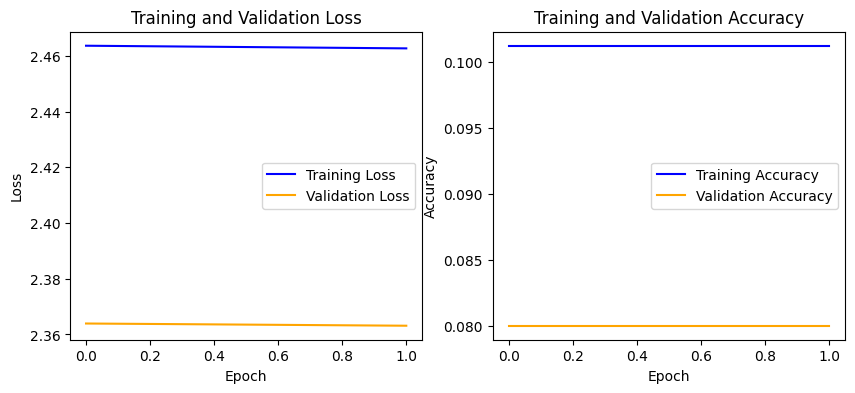

In [87]:
model_name = timestr + ".pth"
# Save the trained model
torch.save(model.state_dict(), 'models/last.pth')

# Plotting the training and validation losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()